In [1]:
import xarray as xr
import rioxarray as rx
import dask
import datacube

import matplotlib.pyplot as plt
from dask.distributed import Client

%matplotlib inline

In [30]:
# 384 hour forecasts for each time (16 * 24)
base = "https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t{time}z.pgrb2.0p25.f{nforecast}&lev_{level}_mb=on&var_{component}=on&subregion=&leftlon={xmin}&rightlon={xmax}&toplat={ymin}&bottomlat={ymax}&dir=%2Fgfs.{date}%2F{time}%2Fatmos"
url = base.format(date='20220301', time='00', nforecast='010', component='VGRD', level=975, xmin=100, xmax=160, ymin=1, ymax=-50)
url

'https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t00z.pgrb2.0p25.f010&lev_975_mb=on&var_VGRD=on&subregion=&leftlon=100&rightlon=160&toplat=1&bottomlat=-50&dir=%2Fgfs.20220301%2F00%2Fatmos'

In [31]:
name = "gfs_{comp}_{date}_t{time}z_f{nf}".format(date='20220301', time='00', nf='010', comp='VGRD'.lower())
outdir = '/home/rvalavi/Downloads'
out = os.path.join(outdir, name)

out

'/home/rvalavi/Downloads/gfs_vgrd_20220301_t00z_f010'

In [32]:
wget.download(url, out)

-1 / unknown

'/home/rvalavi/Downloads/gfs_vgrd_20220301_t00z_f010'

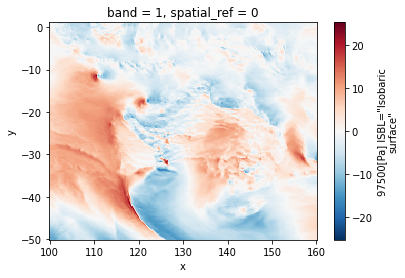

In [276]:
r = rx.open_rasterio(out)
r.plot()

In [3]:
# download GFS wind data
def download_wind(dates, time=12, nforecast=1, components=['VGRD','UGRD'], level=975, outdir="", xmin=100, xmax=160, ymin=1, ymax=-50):
    import os, wget, sys
    # from tqdm import tqdm
    time = str(time).zfill(2) # convert to string and pad 0s if necessary
    if nforecast > 385:
        nforecast = 385
        print("'nforecast' cannot be higher than 385")
    if len(outdir) < 1:
        outdir = os.getcwd()
    # check the arg is a list - for loop
    if isinstance(dates, list):
        date = dates
    else:
        date = []
        date.append(dates)
    # check the arg is a list - for loop
    if isinstance(components, list):
        comps = components
    else:
        comps = []
        comps.append(components)
    base = "https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t{time}z.pgrb2.0p25.f{nf}&lev_{level}_mb=on&var_{comp}=on&subregion=&leftlon={xn}&rightlon={xx}&toplat={yn}&bottomlat={yx}&dir=%2Fgfs.{date}%2F{time}%2Fatmos"       
    for i in date:
        for j in range(nforecast):
            print("Forcast:", j)
            for k in comps:
                nf = str(j).zfill(3) # convert to string and pad 0s if necessary
                name = "gfs_{comp}_{date}_t{time}z_f{nf}".format(comp=k.lower(), date=i, time=time, nf=nf)
                out = os.path.join(outdir, name)            
                url = base.format(date=i, time=time, nf=nf, comp=k.upper(), level=level, xn=xmin, xx=xmax, yn=ymin, yx=ymax)
                # write the file to disk
                wget.download(url, out)
                # print("nforcast", j, "downloaded!")
            

In [5]:
# download 2 days wind forecast
outdir = "/mnt/c/Users/61423/Cesar_projects/WindDispersalFAW/Data/"
download_wind(dates=[20220512], time=00, nforecast=100, outdir=outdir)

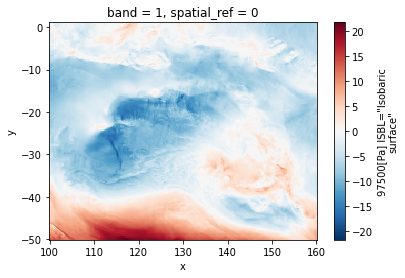

In [7]:
# read one of the files
r = rx.open_rasterio(outdir + "gfs_ugrd_20220505_t00z_f000")
r.plot()

In [6]:
import rioxarray as rio
from datetime import datetime
import os

# read wind data with information
def read_wind(path):
    files = os.listdir(path)
    rlist = []
    for i in files:
        name = os.path.join(path, i)
        _, comp, date, time, fcst = i.split("_")
        r = rio.open_rasterio(name).assign_coords(
            {'date': datetime(int(date[0:4]), int(date[4:6]), int(date[6:8])),
            'time':  str(time),
            'Component': str(comp),
            'Forecast': str(fcst)}
        )
        rlist.append(r)
    stack = xr.concat(rlist, dim = "band")
    return stack

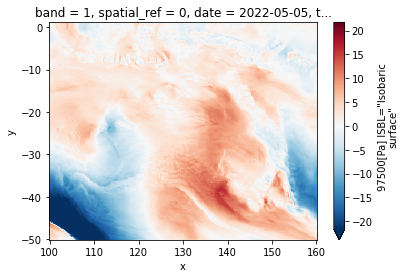

In [7]:
rr = read_wind(path = "/home/rvalavi/Downloads/GFSdata/")

rr[0].plot(robust=True)